1. Написать программу, реализующую симплекс-метод подобно функции из библиотеки SciPy (https://docs.scipy.org/doc/scipy/reference/optimize.linprog-simplex.html) с такими же входными и выходными параметрами.

In [1]:
import numpy as np
import time
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
def simplex_min(c, A_ub=None, b_ub=None, A_eq=None, b_eq=None):
    c = np.array(c)
    if A_ub is not None:
        A_ub = np.array(A_ub)
    if b_ub is not None:
        b_ub = np.array(b_ub)
    if A_eq is not None:
        A_eq = np.array(A_eq)
    if b_eq is not None:
        b_eq = np.array(b_eq)

    num_vars = len(c)
    num_constraints = 0
    if A_ub is not None:
        num_constraints += A_ub.shape[0]
    if A_eq is not None:
        num_constraints += A_eq.shape[0]

    # Создаем начальную таблицу симплекс-метода
    tableau = np.zeros((num_constraints + 1, num_vars + num_constraints + 1))
    tableau[0, :num_vars] = c  # Задаем целевую функцию без изменения знака
    tableau[0, -1] = 0  # Начальное значение целевой функции

    # Заполнение таблицы для ограничений
    if A_ub is not None:
        tableau[1:num_constraints + 1, :num_vars] = A_ub
        tableau[1:num_constraints + 1, -1] = b_ub
        # Добавляем слабые переменные
        tableau[1:num_constraints + 1, num_vars:num_vars + num_constraints] = np.eye(num_constraints)

    # Вывод начальной таблицы
    # print("Начальная таблица:")
    # print(tableau)

    # Основной цикл симплекс-метода
    iteration = 0
    while True:
        # print(f"\nИтерация {iteration}:")
        # print(tableau)

        # Находим индекс входной переменной (столбец с наибольшим отрицательным значением)
        entering = np.argmin(tableau[0, :-1])
        if tableau[0, entering] >= 0:
            break  # Условие оптимальности выполнено

        # Находим индекс выходной переменной (строка с наименьшим положительным соотношением)
        ratios = np.full((num_constraints,), np.inf)  # Инициализируем соотношения как бесконечность
        for i in range(num_constraints):
            if tableau[i + 1, entering] > 0:  # Проверяем только положительные значения
                ratios[i] = tableau[i + 1, -1] / tableau[i + 1, entering]

        leaving = np.argmin(ratios) + 1  # +1 для учета строки заголовка

        # Обновляем таблицу
        pivot = tableau[leaving, entering]
        tableau[leaving, :] /= pivot  # Нормализуем строку выходной переменной
        for i in range(tableau.shape[0]):
            if i != leaving:
                tableau[i, :] -= tableau[i, entering] * tableau[leaving, :]

        iteration += 1

    # Извлечение результатов
    x = np.zeros(num_vars)
    for i in range(1, num_constraints + 1):
        if np.sum(tableau[i, :num_vars] == 1) == 1 and np.sum(tableau[i, :num_vars] == 0) == num_vars - 1:
            x[np.argmax(tableau[i, :num_vars])] = tableau[i, -1]

    # print("\nИтоговая таблица:")
    # print(tableau)

    return {
        'x': x,
        'fun': -tableau[0, -1],  # Изменяем знак, так как мы минимизируем
        'success': True,
        'status': 0,
        'message': 'Optimization terminated successfully.'
    }

def simplex_max(c, A_ub=None, b_ub=None):
    c = np.array(c)
    if A_ub is not None:
        A_ub = np.array(A_ub)
    if b_ub is not None:
        b_ub = np.array(b_ub)

    num_vars = len(c)
    num_constraints = A_ub.shape[0] if A_ub is not None else 0

    # Создаем начальную таблицу симплекс-метода
    tableau = np.zeros((num_constraints + 1, num_vars + num_constraints + 1))
    tableau[0, :num_vars] = c
    tableau[0, -1] = 0

    # Заполнение таблицы для ограничений
    if A_ub is not None:
        tableau[1:num_constraints + 1, :num_vars] = A_ub
        tableau[1:num_constraints + 1, -1] = b_ub
        # Добавляем слабые переменные
        tableau[1:num_constraints + 1, num_vars:num_vars + num_constraints] = np.eye(num_constraints)

    # Основной цикл симплекс-метода
    iteration = 0
    while True:
        # print(f"\nИтерация {iteration}:")
        # print(tableau)

        # Находим индекс входной переменной (столбец с наибольшим значением)
        entering = np.argmax(tableau[0, :-1])
        if tableau[0, entering] <= 0:
            break  # Условие оптимальности выполнено
        # Находим индекс выходной переменной (строка с наименьшим положительным соотношением)
        ratios = np.full((num_constraints,), np.inf)  # Инициализируем соотношения как бесконечность
        for i in range(num_constraints):
            if tableau[i + 1, entering] > 0:  # Проверяем только положительные значения
                ratios[i] = tableau[i + 1, -1] / tableau[i + 1, entering]
            else:
                ratios[i] = np.inf  # Если не положительное, задаем бесконечность

        # Проверка на случай, если все значения в ratios равны бесконечности
        if np.all(ratios == np.inf):
            print("Ошибка: нет положительной выходной переменной. Остановка.")
            break

        leaving = np.argmin(ratios) + 1  # +1 для учета строки заголовка

        # Обновляем таблицу
        pivot = tableau[leaving, entering]
        tableau[leaving, :] /= pivot  # Нормализуем строку выходной переменной
        for i in range(tableau.shape[0]):
            if i != leaving:
                tableau[i, :] -= tableau[i, entering] * tableau[leaving, :]

        iteration += 1

    # Извлечение результатов
    x = np.zeros(num_vars)
    for i in range(1, num_constraints + 1):
        if np.sum(tableau[i, :num_vars] == 1) == 1 and np.sum(tableau[i, :num_vars] == 0) == num_vars - 1:
            x[np.argmax(tableau[i, :num_vars])] = tableau[i, -1]

    # print("\nИтоговая таблица:")
    # print(tableau)

    return {
        'x': x,
        'fun': tableau[0, -1],  # Мы максимизируем, поэтому берем значение без изменения
        'success': True,
        'status': 0,
        'message': 'Optimization terminated successfully.'
    }



# Функция для тестирования задач
def run_test(c, A_ub, b_ub):
    print("\nТестовая задача:")
    print("Целевая функция:", c)
    print("Ограничения A_ub:", A_ub)
    print("Ограничения b_ub:", b_ub)

    # Запуск реализации
    start_time = time.time()
    my_result = simplex_min(c, A_ub=A_ub, b_ub=b_ub)
    #my_result = simplex_max(c, A_ub=A_ub, b_ub=b_ub)
    my_time = time.time() - start_time

    # Запуск функции scipy
    start_time = time.time()
    scipy_result = linprog(c, A_ub=A_ub, b_ub=b_ub, method='simplex')
    scipy_time = time.time() - start_time

    # Печать результатов
    print("\nРезультаты нашей реализации:")
    print("x:", my_result['x'])
    print("fun:", my_result['fun'])
    print("success:", my_result['success'])
    print("Время выполнения нашей реализации:", my_time)

    print("\nРезультаты функции scipy:")
    print("x:", scipy_result.x)
    print("fun:", scipy_result.fun)
    print("success:", scipy_result.success)
    print("Время выполнения функции scipy:", scipy_time)
    print("\n------------------------------\n")


# Примеры задач
tests = [
    ([-1, -2], [[2, 1], [1, 1], [1, 0]], [20, 16, 8]),  
    ([3, 2], [[-2, -1], [-1, 0]], [-10, -5]),  
    ([-2, -1], [[-1, -2], [1, 1], [0, 1]], [-4, 10, 6]),  
    ([1, 3], [[2, 1], [1, 1], [1, 0]], [20, 16, 8]), 
    ([1, 2], [[1, 1], [-1, 2], [-2, -1]], [15, 10, 5]) 
]

# Запуск тестов
for c, A_ub, b_ub in tests:
    run_test(c, A_ub, b_ub)


Тестовая задача:
Целевая функция: [-1, -2]
Ограничения A_ub: [[2, 1], [1, 1], [1, 0]]
Ограничения b_ub: [20, 16, 8]

Результаты нашей реализации:
x: [8. 0.]
fun: -32.0
success: True
Время выполнения нашей реализации: 0.0

Результаты функции scipy:
x: [ 0. 16.]
fun: -32.0
success: True
Время выполнения функции scipy: 0.00498652458190918

------------------------------


Тестовая задача:
Целевая функция: [3, 2]
Ограничения A_ub: [[-2, -1], [-1, 0]]
Ограничения b_ub: [-10, -5]

Результаты нашей реализации:
x: [0. 0.]
fun: -0.0
success: True
Время выполнения нашей реализации: 0.0

Результаты функции scipy:
x: [5. 0.]
fun: 15.0
success: True
Время выполнения функции scipy: 0.0019948482513427734

------------------------------


Тестовая задача:
Целевая функция: [-2, -1]
Ограничения A_ub: [[-1, -2], [1, 1], [0, 1]]
Ограничения b_ub: [-4, 10, 6]

Результаты нашей реализации:
x: [0. 6.]
fun: -20.0
success: True
Время выполнения нашей реализации: 0.0

Результаты функции scipy:
x: [10.  0.]
fun

2. Для двумерной задачи написать функцию, визуализирующую решение как в https://proglib.io/p/lineynoe-programmirovanie-praktika-resheniya-zadach-optimizacii-na-python-2020-11-26, но также добавить целевую функцию на график. 

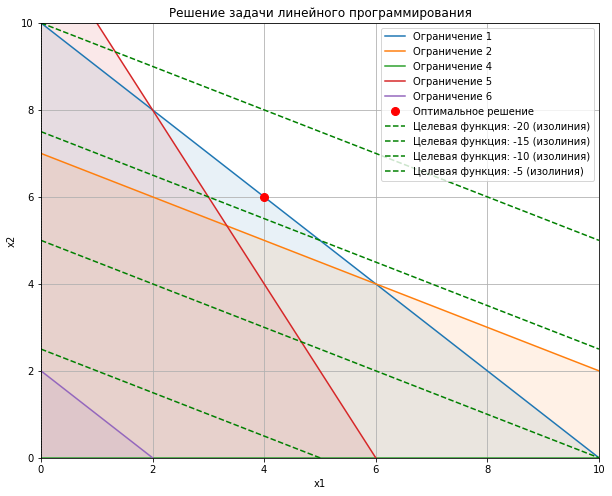

In [3]:
def plot_linear_programming_solution(A, b, c, x_opt):
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Определяем диапазоны для переменных
    x = np.linspace(0, 10, 400)
    
    # Визуализируем ограничения
    for i in range(len(A)):
        if A[i, 1] != 0:
            y = (b[i] - A[i, 0] * x) / A[i, 1]
            ax.plot(x, y, label=f'Ограничение {i + 1}')
            ax.fill_between(x, y, 0, where=(y >= 0), alpha=0.1)

    # Отметим оптимальное решение
    ax.plot(x_opt[0], x_opt[1], 'ro', label='Оптимальное решение', markersize=8)

    # Визуализируем целевую функцию (изолинии)
    x0 = np.linspace(0, 10, 400)
    for k in range(-20, 0, 5):  # Изолинии целевой функции
        y0 = (k - c[0] * x0) / c[1]
        ax.plot(x0, y0, 'g--', label=f'Целевая функция: {k} (изолиния)')

    # Устанавливаем границы графика
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    
    # Подписываем оси
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.axhline(0, color='black', linewidth=0.5, ls='--')
    ax.axvline(0, color='black', linewidth=0.5, ls='--')

    # Добавляем легенду и показываем график
    ax.legend()
    plt.title('Решение задачи линейного программирования')
    plt.grid()
    plt.show()

# Пример использования функции
A = np.array([[1, 1], [1, 2], [-1, 0], [0, -1], [2, 1], [-1, -1]])  # ограничения
b = np.array([10, 14, 0, 0, 12, -2])                              # Вектор правых частей
c = np.array([-1, -2])                                           # Коэффициенты целевой функции(минимизация)(для максимизации ставим +)
x_opt = np.array([4, 6])                                        # Оптимальное решение в области допустимых решений

plot_linear_programming_solution(A, b, c, x_opt)